In [1]:
import sys
import os
import random
import json
import numpy as np
from collections import defaultdict
from importlib import reload
from matplotlib import pyplot as plt

import torch
from torchvision import transforms

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

torch.set_printoptions(precision=2,sci_mode=False)

from openloris.OpenLorisDataset import OpenLorisDataset
from openloris import full_streaming_experiment
import models.CLP 
from models.StreamingLDA import StreamingLDA
from models.StreamingSoftmaxReplay import StreamingSoftmax
from utils import get_backbone
from openloris.open_loris_utils import get_stream_data_loader, get_class_change_boundaries, \
update_and_save_accuracies_ood, update_and_save_accuracies, update_and_save_accuracies_semi_supervised,\
get_class_change_boundaries, get_ood_loaders, save_model_size

In [2]:
batch_size = 64
dataset_name = "openloris"
images_dir = "/home/ehajizad/datasets/OpenLORIS"
save_dir_results = "/home/ehajizad/dev/CLP-Embedded-CL/images/"
arch='efficientnet_b0'
label_level = 'class'
training = True
seed = 10
step_size = 32
num_classes = 40
test_order = None
perform_ood = True
ood_num_samples = 10000
ood_type = 'baseline'
device = 'cuda'
backbone, feature_size = get_backbone(arch, 'avg')
random.seed(seed)

/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
expt_name = "clp_novelty_detection_new/"

accuracies = {'base_acc_init': [], 'base_acc_final': [], 'novel_acc': [], 'auroc_score_intra': [], 'auosc_score_intra': [],
                      'auosc_norm_score_intra': [], 'base_model_size': [], 'final_model_size': []}

save_dir = save_dir_results + expt_name

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [9]:
reload(models.CLP)
from models.CLP import ContinuallyLearningPrototypes


classifier_types = ["Replay (20pc)", "SLDA", "CLP"]
seeds = [20, 30]
ood_num_samples = 8000

scores = np.zeros(shape=(len(seeds), len(classifier_types), 2, ood_num_samples*2))

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for s, seed in enumerate(seeds):

    all_classes = list(range(num_classes))
    random.seed(seed) # set initial random seed
    random.shuffle(all_classes)

    base_classes = all_classes[:20]
    new_classes = all_classes[20:]

    tr_closed = get_stream_data_loader(images_dir, True, batch_size=batch_size,
                                    ordering='instance',
                                    shuffle=False, augment=True, seed=seed, label_level='class',
                                    dataset=dataset_name, seen_classes=base_classes)

    
    test_loader_full = get_stream_data_loader(images_dir, False, ordering=test_order, batch_size=batch_size, seed=seed,
                                            seen_classes=None, label_level=label_level, dataset=dataset_name)

    in_loader, out_loader_intra = get_ood_loaders(test_loader_full, num_classes,
                                                    batch_size, ood_num_samples,
                                                    seen_classes=base_classes,
                                                    dataset=dataset_name)
    

    
    for c, classifier_type in enumerate(classifier_types):
        
        if classifier_type == 'slda':
            classifier = StreamingLDA(feature_size, num_classes, backbone=backbone,
                                    shrinkage_param=1e-4, streaming_update_sigma=True,
                                    ood_type='mahalanobis')
        elif classifier_type == 'Replay (20pc)':
                classifier = StreamingSoftmax(feature_size, num_classes, use_replay=True, backbone=backbone,
                                                lr=0.001, weight_decay=1e-5, replay_samples=50,
                                                max_buffer_size=800)
        elif classifier_type == 'clp':
                classifier = ContinuallyLearningPrototypes(feature_size,
                                                        n_protos=2500,
                                                        num_classes=num_classes, 
                                                        backbone=backbone,
                                                        alpha_init=1,
                                                        sim_th_init=0.75,
                                                        n_wta=5,
                                                        k_hit=1,
                                                        k_miss=0.5,
                                                        adaptive_th=False,
                                                        learn_outliers=True,
                                                        device=device)

        

        print('---------------------------------------------------------------------------')
        print('Beginning base streaming training of base classes...')
        i = 0
        test_classes = base_classes
        for batch_ix, (batch_x, batch_y) in enumerate(tr_closed):

            batch_x_feat = classifier.backbone(batch_x.to(device)).detach()

            for x, y in zip(batch_x_feat, batch_y):

                # fit model
                classifier.fit(x, y.view(1, ), torch.tensor(i).long())
                i += 1


        # print('\nMaking test loader from all test data for learned classes: ')
        # test_loader = get_stream_data_loader(images_dir, False, ordering=test_order, batch_size=batch_size,
        #                                         seen_classes=test_classes, label_level=label_level, dataset=dataset_name)
        # probas, y_test_init = classifier.evaluate_(test_loader)
        # update_and_save_accuracies_semi_supervised(probas, y_test_init, save_dir, 0, accuracies, 0)

        # ----------------------------------------------------------------------------#
        # OOD test

        print("Beginning OOD testing")
        
        ood_scores_in, true_labels_in = classifier.evaluate_ood_(in_loader)
        ood_scores_out, true_labels_out = classifier.evaluate_ood_(out_loader_intra)

        # update_and_save_accuracies_ood(ood_scores_in, true_labels_in, ood_scores_out,
        #                                 true_labels_out, save_dir, s, accuracies)

        s_in, p_in = ood_scores_in.max(dim=1)
        s_out, _ = ood_scores_out.max(dim=1)

        num_in_samples = len(ood_scores_in.numpy())
        num_out_samples = len(ood_scores_out.numpy())

        y_true_ood = np.concatenate((np.zeros(num_in_samples), np.ones(num_out_samples)))
        y_scores = np.concatenate((s_in.numpy(), s_out.numpy()))

        scores[s,c,:] = y_true_ood, y_scores

Num OOD samples  8000
Making in-loader from these classes:  [25, 8, 5, 29, 38, 7, 11, 17, 32, 0, 12, 39, 30, 34, 22, 27, 2, 24, 19, 21]
Inloader made from 20 classes (8000 samples)
Inloader made from 20 classes (8000 samples)
Outloader made from 20 classes (8000 samples)
---------------------------------------------------------------------------
Beginning base streaming training of base classes...
Sample 214362 -- train_loss=0.007144 -- buffer_size=799Beginning OOD testing

Testing OOD on 8000 images.

Testing OOD on 8000 images.
Num OOD samples  8000
Making in-loader from these classes:  [38, 36, 31, 29, 15, 26, 23, 22, 37, 6, 4, 10, 9, 21, 39, 33, 20, 32, 17, 11]
Inloader made from 20 classes (8000 samples)
Inloader made from 20 classes (8000 samples)
Outloader made from 20 classes (8000 samples)
---------------------------------------------------------------------------
Beginning base streaming training of base classes...
Sample 237120 -- train_loss=0.006567 -- buffer_size=799Beginn

In [7]:
scores = np.load("all_ood_scores.npy")

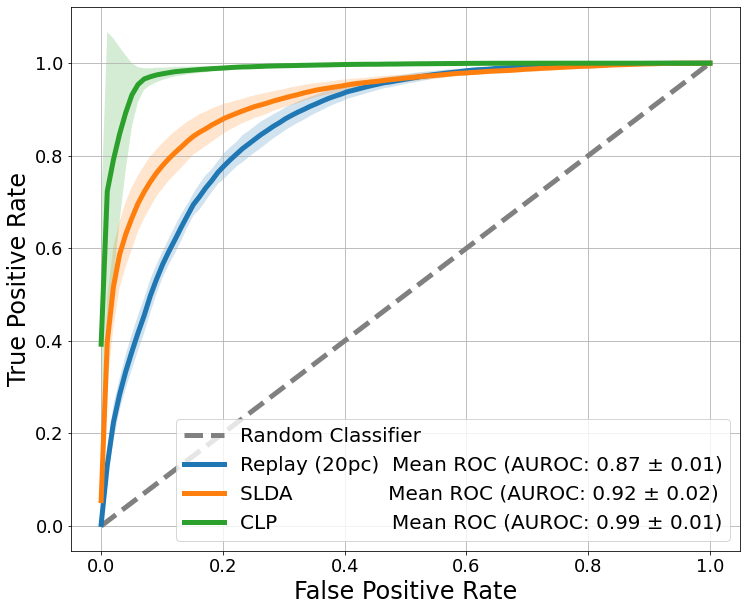

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import stats

# Assume scores is already defined with shape (n_seeds, n_classifiers, 2, 16000)

classifier_types = ["Replay (20pc) ",
                    "SLDA              ",
                    "CLP                 "]

# Set up plot
fig = plt.figure(figsize=(12, 10))

# Confidence level and corresponding Z-score
confidence_level = 0.95  # You can change this to 0.90, 0.99, etc.
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

# No-skill classifier (random guessing)
no_skill_fpr = np.linspace(0, 1, 100)
no_skill_tpr = no_skill_fpr  # ROC curve of a no-skill classifier is a diagonal line

# Plot no-skill classifier
plt.plot(no_skill_fpr, no_skill_tpr, linestyle='--', color='gray', label='Random Classifier',linewidth=5)

# Iterate over each classifier
for i in range(scores.shape[1]):
    all_fpr = np.linspace(0, 1, 100)  # Common FPR axis for interpolation
    tprs = []  # Store TPRs for each seed
    aurocs = []  # Store AUROCs for each seed
    
    # Iterate over each seed
    for s in range(scores.shape[0]):
        y_true_ood = scores[s, i, 0, :]
        y_scores = -scores[s, i, 1, :]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true_ood, y_scores, pos_label=1)
        
        # Calculate AUROC
        roc_auc = auc(fpr, tpr)
        aurocs.append(roc_auc)
        
        # Interpolate to the common FPR points
        interp_tpr = np.interp(all_fpr, fpr, tpr)
        tprs.append(interp_tpr)
    
    # Convert list to array for easier calculation
    tprs = np.array(tprs)
    
    # Calculate mean and SEM for TPR
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    sem_tpr = std_tpr / np.sqrt(len(tprs))  # Standard Error of the Mean (SEM)
    
    # Calculate 95% confidence interval using Z-score
    ci = z_score * sem_tpr
    
    # Calculate average AUROC and its standard deviation
    mean_auc = np.mean(aurocs)
    std_auc = np.std(aurocs)
    
    # Plot mean ROC curve
    plt.plot(all_fpr, mean_tpr, linewidth=5,
              label=f'{classifier_types[i]} Mean ROC (AUROC: {mean_auc:.2f} ± {std_auc:.2f})')
    
    # Plot the shaded region (mean ± CI)
    plt.fill_between(all_fpr, mean_tpr - ci, mean_tpr + ci, alpha=0.2)
    


# Add plot details with larger text
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
# plt.title('ROC Curves with 95% Confidence Interval, No Skill Classifier, and AUROC', fontsize=16)
plt.legend(loc='lower right', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

save_name = 'ROC_novelty'
if save_dir is not None:
    fig.savefig(os.path.join(save_dir, save_name + '.png'), bbox_inches="tight", format='png', dpi=600)


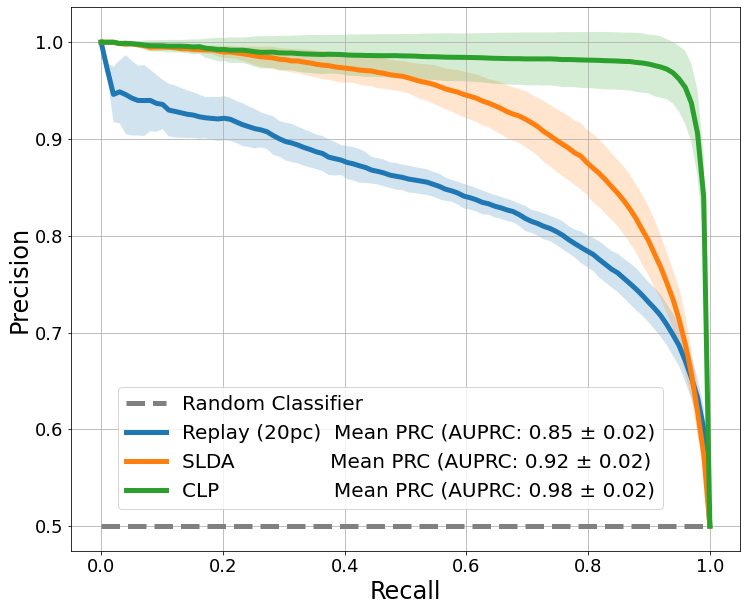

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy import stats

# Assume scores is already defined with shape (n_seeds, n_classifiers, 2, 16000)

# Set up plot
fig = plt.figure(figsize=(12, 10))

# Confidence level and corresponding Z-score
confidence_level = 0.95  # You can change this to 0.90, 0.99, etc.
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

# Plot no-skill classifier (random guessing)
no_skill_recall = np.linspace(0, 1, 100)
no_skill_precision = [0.5] * 100  # Precision of 0.5 for a no-skill classifier

# Plot no-skill classifier
plt.plot(no_skill_recall, no_skill_precision, linestyle='--', color='gray', label='Random Classifier', linewidth=5)

# Iterate over each classifier
for i in range(scores.shape[1]):
    all_recall = np.linspace(0, 1, 100)  # Common Recall axis for interpolation
    precisions = []  # Store precision values for each seed
    auprcs = []  # Store AUPRCs for each seed
    
    # Iterate over each seed
    for s in range(scores.shape[0]):
        y_true_ood = scores[s, i, 0, :]
        y_scores = -scores[s, i, 1, :]
        
        # Calculate Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_true_ood, y_scores, pos_label=1)
        
        # Calculate AUPRC
        pr_auc = average_precision_score(y_true_ood, y_scores)
        auprcs.append(pr_auc)
        
        # Interpolate to the common Recall points
        interp_precision = np.interp(all_recall, recall[::-1], precision[::-1])  # Reverse recall and precision for interpolation
        precisions.append(interp_precision)
    
    # Convert list to array for easier calculation
    precisions = np.array(precisions)
    
    # Calculate mean and SEM for Precision
    mean_precision = np.mean(precisions, axis=0)
    std_precision = np.std(precisions, axis=0)
    sem_precision = std_precision / np.sqrt(len(precisions))  # Standard Error of the Mean (SEM)
    
    # Calculate 95% confidence interval using Z-score
    ci = z_score * sem_precision
    
    # Calculate average AUPRC and its standard deviation
    mean_auprc = np.mean(auprcs)
    std_auprc = np.std(auprcs)
    
    # Plot mean PRC
    plt.plot(all_recall, mean_precision, linewidth=5,
             label=f'{classifier_types[i]} Mean PRC (AUPRC: {mean_auprc:.2f} ± {std_auprc:.2f})')

    # Plot the shaded region (mean ± CI)
    plt.fill_between(all_recall, mean_precision - ci, mean_precision + ci, alpha=0.2)
    

# Add plot details with larger text
plt.xlabel('Recall', fontsize=24)
plt.ylabel('Precision', fontsize=24)
# plt.title('Precision-Recall Curves with 95% Confidence Interval, No Skill Classifier, and AUPRC', fontsize=16)
plt.legend(loc='upper right', fontsize=20, bbox_to_anchor=(0.9, 0.32))  # Adjust legend position
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

save_name = 'PRC_novelty'
if save_dir is not None:
    fig.savefig(os.path.join(save_dir, save_name + '.png'), bbox_inches="tight", format='png', dpi=600)


In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


fig = plt.figure(figsize=(13,8))
lr_fpr_list = []
lr_tpr_list = []
auroc_list = []

# Common set of false positive rates (linspace)
common_fpr = np.linspace(0, 1, 100)

for i in range(scores.shape[1]-1):
    for s in range(3):
        y_true_ood = scores[s,i,0,:]
        y_scores = -scores[s,i,1,:]
        
        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(y_true_ood))]
        
        ns_fpr, ns_tpr, _ = roc_curve(y_true_ood, ns_probs, )
        lr_fpr, lr_tpr, _ = roc_curve(y_true_ood, y_scores, pos_label=1)

        interp_tpr1 = np.interp(common_fpr, fpr1, tpr1)
        interp_tpr2 = np.interp(common_fpr, fpr2, tpr2)
        interp_tpr3 = np.interp(common_fpr, fpr3, tpr3)

        auroc_list.append(roc_auc_score(y_true_ood, y_scores))
        lr_fpr_list.append(lr_fpr)
        lr_tpr_list.append(lr_tpr)
        print(lr_fpr.shape,lr_tpr.shape )

    tpr = np.vstack(lr_tpr_list)
    spr = np.vstack(lr_fpr_list)
    mean_tpr = np.mean(tpr, axis=0)
    std_tpr = np.std(tpr, axis=0)    
    mean_spr = np.mean(spr, axis=0)
    std_spr = np.std(spr, axis=0)    

    if i==0:
        plt.plot(mean_spr[::20], mean_tpr[::20], marker='.', label='SLDA')
    else:
        plt.plot(mean_spr[::20], mean_tpr[::20], marker='.', label='CLP')
    
    
    # axis labels
    plt.xlabel('False Positive Rate',fontsize=22)
    plt.ylabel('True Positive Rate',fontsize=22)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    
    
    # print("th: ",th, "auroc: ", np.around(auroc,3))

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Classifier')
plt.legend(fontsize=18)
plt.show()

save_name = 'ROC_novelty'
if save_dir is not None:
    fig.savefig(os.path.join(save_dir, save_name + '.png'), bbox_inches="tight", format='png', dpi=600)

NameError: name 'fpr1' is not defined

<Figure size 936x576 with 0 Axes>

0.937
0.953
0.962
0.972
0.978
0.985
0.991
0.926
0.931


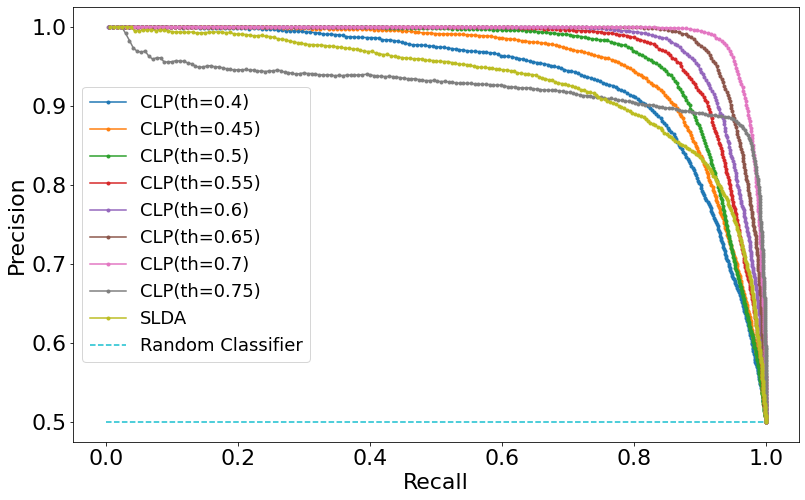

In [28]:
fig = plt.figure(figsize=(13,8))
for i in range(len(scores)):
    y_true_ood = scores[i][1]
    y_scores = -scores[i][2]
    th = scores[i][0]
    
    # y_scores[8000]= -1e-18
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_true_ood))]
    
    no_skill = len(y_true_ood[y_true_ood==1]) / len(y_true_ood)
    lr_precision, lr_recall, _ = precision_recall_curve(y_true_ood, y_scores)
    
    if i==len(scores)-1:
        plt.plot(lr_recall[::50], lr_precision[::50], marker='.', label='SLDA')
    else:
        plt.plot(lr_recall[::50], lr_precision[::50], marker='.', label='CLP(th='+str(th)+")")
    
    
    # axis labels
    plt.xlabel('Recall', fontsize=22)
    plt.ylabel('Precision',fontsize=22)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    
    lr_auc = auc(lr_recall, lr_precision)
    print(np.around(lr_auc,3))
    # print("th: ",th, "auprc: ", lr_auc)
    
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Classifier')
plt.legend(fontsize=18)
plt.show()

save_name = 'Prec_recall_novelty'
if save_dir is not None:
    fig.savefig(os.path.join(save_dir, save_name + '.png'), bbox_inches="tight", format='png', dpi=600)

In [14]:

clp_pr_rc_f1 = []
# th_range = np.arange(-30000, -1000, 200)
for i in range(len(scores)-1):
    y_true_ood = scores[i][1]
    y_scores = scores[i][2]
    th = scores[i][0]
    
    y_pred_ood = y_scores < th

    precision, recall, fscore, _ = precision_recall_fscore_support(y_true_ood, y_pred_ood, average='binary')

    clp_pr_rc_f1.append([np.around(precision,2), np.around(recall,2), np.around(fscore,2)] )
    # print(pr_rc_f1[-1])    

clp_pr_rc_f1 = np.array(clp_pr_rc_f1)


In [15]:
clp_pr_rc_f1

array([[1.  , 0.05, 0.09],
       [1.  , 0.11, 0.2 ],
       [1.  , 0.22, 0.36],
       [1.  , 0.41, 0.58],
       [1.  , 0.62, 0.76],
       [1.  , 0.76, 0.86],
       [1.  , 0.85, 0.92],
       [0.89, 0.92, 0.91]])

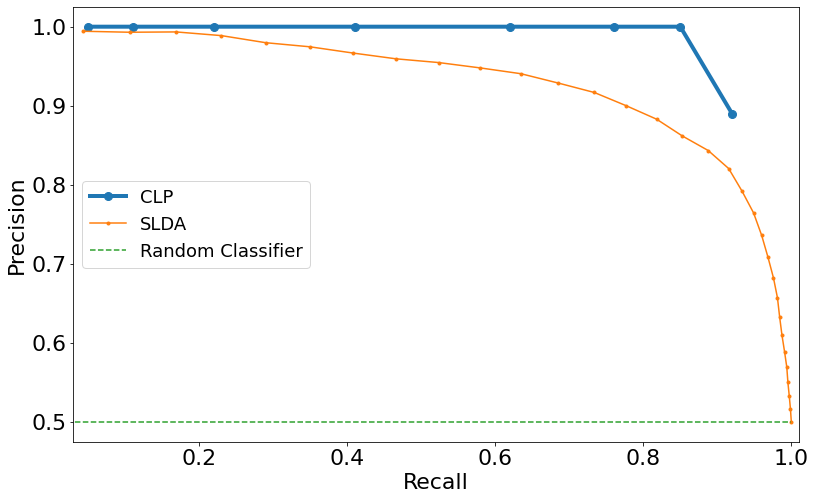

In [27]:
fig=plt.figure(figsize=(13,8))
    
y_true_ood = scores[-1][1]
y_scores = -scores[-1][2]

ns_probs = [0 for _ in range(len(y_true_ood))]

no_skill = len(y_true_ood[y_true_ood==1]) / len(y_true_ood)
lr_precision, lr_recall, thresholds = precision_recall_curve(y_true_ood, y_scores)
lr_precision, lr_recall = lr_precision[::500], lr_recall[::500]

plt.plot(clp_pr_rc_f1[:,1], clp_pr_rc_f1[:,0], marker='.', label='CLP', linewidth=4, markersize=16)
plt.plot(lr_recall, lr_precision, marker='.', label='SLDA')


# axis labels
plt.xlabel('Recall', fontsize=22)
plt.ylabel('Precision',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.xlim([0.03,1.01])
    
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Classifier')
plt.legend(fontsize=18)
plt.show()

save_name = 'real_prec_recall_novelty'
if save_dir is not None:
    fig.savefig(os.path.join(save_dir, save_name + '.png'), bbox_inches="tight", format='png', dpi=600)

In [35]:
thresholds

array([ 240.9521 ,  241.55135,  251.56505, ..., 4318.5586 , 4663.9575 ,
       4831.506  ], dtype=float32)

In [38]:
min(y_scores), max(y_scores)

(-4831.506, -240.9521)

In [41]:
# th_range = np.arange(-30000, -1000, 200)
y_true_ood = scores[-1][1]
y_scores = scores[-1][2]
for mah_th in np.arange(-4831, -240, 100):
    
    y_pred_ood = y_scores < mah_th

    precision, recall, fscore, _ = precision_recall_fscore_support(y_true_ood, y_pred_ood, average='binary')

    # clp_pr_rc_f1.append([np.around(precision,2), np.around(recall,2), np.around(fscore,2)] )
    print(mah_th, np.around(precision,2), np.around(recall,2), np.around(fscore,2))    



-4831 1.0 0.0 0.0
-4731 1.0 0.0 0.0
-4631 1.0 0.0 0.0
-4531 1.0 0.0 0.0
-4431 1.0 0.0 0.0
-4331 1.0 0.0 0.0
-4231 1.0 0.0 0.0
-4131 1.0 0.0 0.0
-4031 1.0 0.0 0.0
-3931 1.0 0.0 0.0
-3831 1.0 0.0 0.0
-3731 1.0 0.0 0.0
-3631 1.0 0.0 0.0
-3531 1.0 0.0 0.0
-3431 1.0 0.0 0.0
-3331 1.0 0.0 0.0
-3231 1.0 0.0 0.0
-3131 1.0 0.0 0.0
-3031 1.0 0.0 0.0
-2931 1.0 0.0 0.0
-2831 1.0 0.0 0.0
-2731 1.0 0.0 0.0
-2631 1.0 0.0 0.01
-2531 1.0 0.0 0.01
-2431 1.0 0.01 0.01
-2331 1.0 0.01 0.01
-2231 1.0 0.01 0.02
-2131 1.0 0.02 0.03
-2031 1.0 0.03 0.05
-1931 1.0 0.04 0.07
-1831 1.0 0.06 0.11
-1731 1.0 0.08 0.16
-1631 0.99 0.12 0.22
-1531 0.99 0.18 0.31
-1431 0.99 0.26 0.41
-1331 0.97 0.34 0.51
-1231 0.96 0.45 0.61
-1131 0.95 0.57 0.71
-1031 0.93 0.69 0.79
-931 0.89 0.81 0.85
-831 0.84 0.9 0.87
-731 0.76 0.95 0.85
-631 0.68 0.98 0.8
-531 0.6 0.99 0.74
-431 0.54 1.0 0.7
-331 0.51 1.0 0.67


In [56]:
np_scores = np.array(scores, dtype=object)
np.save(save_dir+"/ood_score_full_shot.npy",np_scores)

In [8]:
scores = np.load(save_dir+"/ood_score_full_shot.npy", allow_pickle=True)

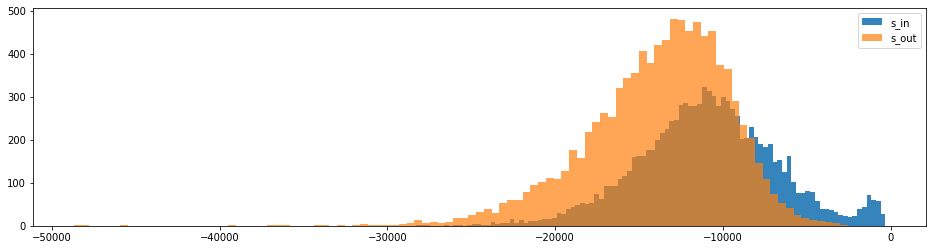

In [149]:
plt.figure(figsize=(16, 4))

# Plot the first histogram (s_in)
plt.hist(s_in, 100, alpha=0.9, label='s_in')  # Adjust alpha to control transparency

# Plot the second histogram (s_out) with higher transparency
plt.hist(s_out, 100, alpha=0.7, label='s_out')  # Adjust alpha to control transparency

plt.legend()  # Show legend for labeled histograms
plt.show()